<a href="https://colab.research.google.com/github/brendanhasz/embedding-regression/blob/master/TFP_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tfp-nightly

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

# Data

In [0]:
# Generate fake data
D = 4
N = 100
W = np.random.randn(D).astype(np.float32)
x = np.random.randn(N, D).astype(np.float32)
noise = np.random.randn(N).astype(np.float32)
y = np.matmul(x, W) + noise

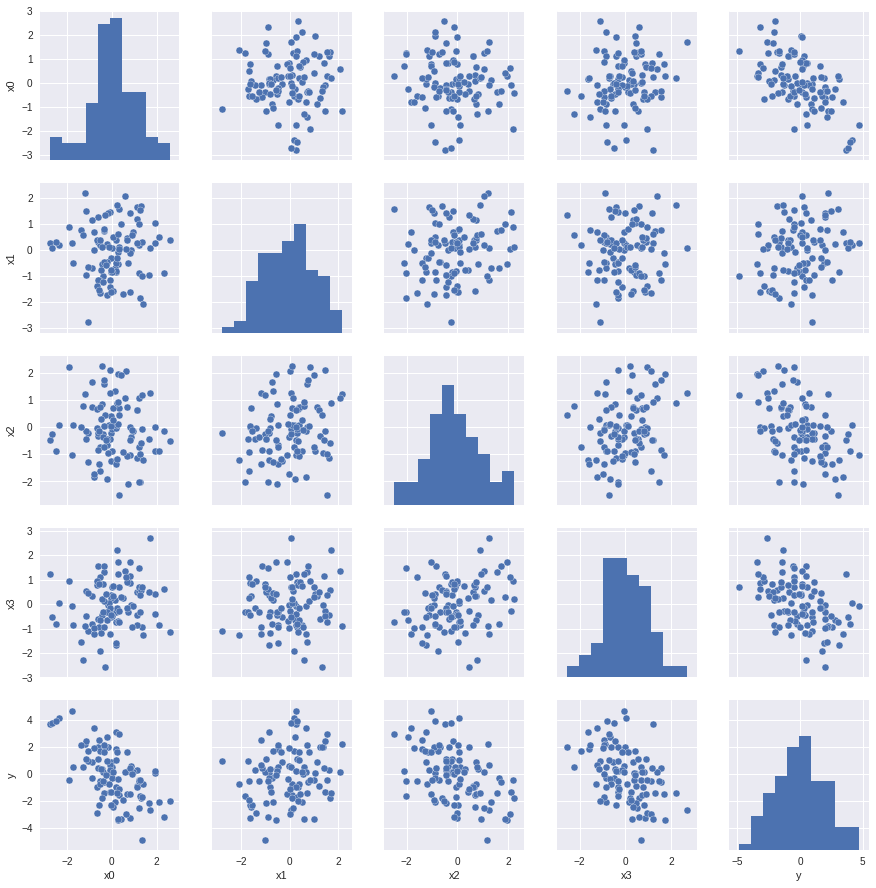

In [141]:
# Show data
sns.pairplot(pd.DataFrame(np.c_[x, y],
                          columns=['x0', 'x1', 'x2', 'x3', 'y']))
plt.show()

# Model

A basic Bayesian linear regression

\begin{align*}
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{HalfNormal}(1) \\
y_i &\sim \text{Normal}(x_i^\top \beta, ~ \sigma^2)
\end{align*}



In [0]:
def linear_regression(features):
  """Bayesian linear regression, which returns predictions given features."""
  D = features.shape[1]
  coeffs = ed.Normal( #normal prior on weights
      loc=tf.zeros([D,1]),
      scale=tf.ones([D,1]),
      name="coeffs")
  noise_std = ed.HalfNormal( #half-normal prior on noise std
      scale=1,
      name="noise_std")
  predictions = ed.Normal( #normally-distributed noise around predicted values
      loc=tf.matmul(features, coeffs),
      scale=noise_std,
      name="predictions")
  return predictions

log_joint = ed.make_log_joint_fn(linear_regression)

def target_log_prob_fn(coeffs, noise_std):
  """Target density."""
  return log_joint(
      features=x,
      coeffs=coeffs,
      noise_std=noise_std,
      predictions=y[:,np.newaxis])

# Bayesian Inference

Yadda yadda

In [143]:
# HMC Settings
num_results = 8000 #number of hmc iterations
n_burnin = 4000
step_size = 0.05 #works w/ 100 datapoints?
num_leapfrog_steps = 5

# Parameter sizes
coeffs_size = [4,1]
noise_std_size = [1]

t0 = time.time()

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=n_burnin,
    current_state=[
        tf.zeros(coeffs_size, name='init_coeffs'),
        tf.ones([], name='init_noise_std'),
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=step_size,
        num_leapfrog_steps=num_leapfrog_steps))

coeffs, noise_std = states

with tf.Session() as sess:
  [
      coeffs_,
      noise_std_,
      is_accepted_,
  ] = sess.run([
      coeffs,
      noise_std,
      kernel_results.is_accepted,
  ])


# Remove samples from burn-in
coeffs_samples = coeffs_[n_burnin:,:,0]
noise_std_samples = noise_std_[n_burnin:]
accepted_samples = is_accepted_[n_burnin:]

print('Elapsed time: ', time.time()-t0)

Elapsed time:  9.75632095336914


Talk about acceptance rate.  

Sounds like an acceptance rate of about 0.234 is "optimal".  http://dx.doi.org/10.1214/aoap/1034625254


In [144]:
print('Acceptance rate: ', np.mean(accepted_samples))

Acceptance rate:  0.9435


TODO: talk about looking @ posterior distribution

dist is the posterior, solid line is true val, dotted lines show 95% conf interval

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

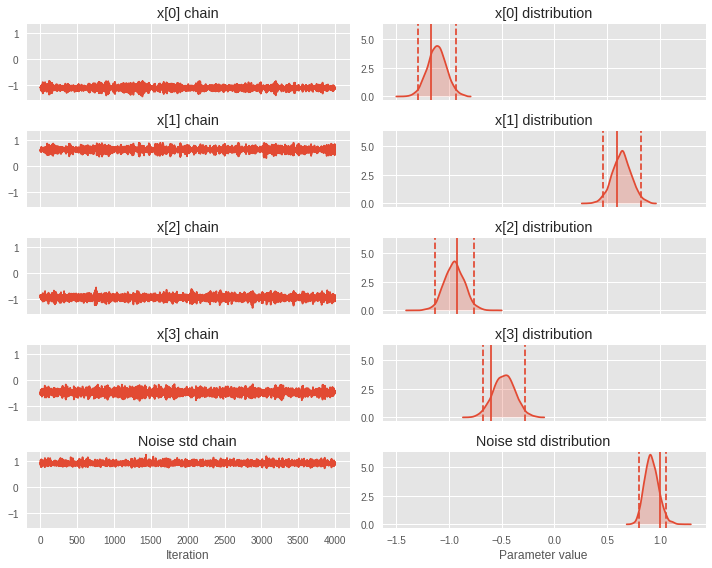

In [147]:
def chain_plot(data, title='', ax=None):
  if ax is None:
    ax = plt.gca()
  ax.plot(data)
  ax.title.set_text(title+" chain")
  
def post_plot(data, title='', ax=None, true=None, prc=95):
  if ax is None:
    ax = plt.gca()
  sns.kdeplot(data, ax=ax, shade=True)
  ax.axvline(x=np.percentile(data, (100-prc)/2), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-(100-prc)/2), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)
    
def chain_post_plot(data, title='', ax=None, true=None):
  chain_plot(data, title=title, ax=ax[0])
  post_plot(data, title=title, ax=ax[1], true=true)
  
# Plot chains and distributions for coefficients
plt.style.use("ggplot")
fig, axes = plt.subplots(5, 2, sharex='col', sharey='col')
fig.set_size_inches(10, 8)
for i in range(4):
  chain_post_plot(coeffs_samples[:,i],
                  title="x[{}]".format(i),
                  ax=axes[i], true=W[i])
  
# and for noise std dev
chain_post_plot(noise_std_samples,
                title="Noise std",
                ax=axes[4], true=1)
  
axes[4][0].set_xlabel("Iteration")
axes[4][1].set_xlabel("Parameter value")
fig.tight_layout()
plt.show()

# Prediction Intervals

TODO (generate prediction intervals for test data)

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


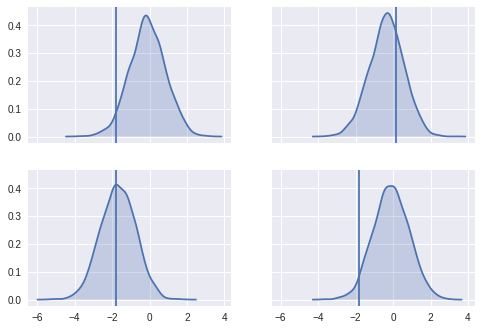

In [146]:
def prediction_interval(x):
  predictions = np.matmul(x, coeffs_samples.transpose())
  noise = noise_std_samples*np.random.randn(noise_std_samples.shape[0])
  return predictions + noise

# Plot random datapoints and their prediction intervals
sns.set()
fig, axes = plt.subplots(2, 2, sharex='all', sharey='all')
for i in range(2):
  for j in range(2):
    ix = np.random.randint(0, N)
    pred_int = prediction_interval(x[ix,:])
    sns.kdeplot(pred_int, shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y[ix])

# Criticism

TODO